In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import math

In [2]:
source_data =pd.read_csv(r"F:\数据集样本划分\轴承数据库\cwru\12k_de_cwru_data_load2_0.007.csv").values
source_label=pd.read_csv(r"F:\数据集样本划分\轴承数据库\cwru\12k_de_cwru_label_load2_0.007.csv").values

target_data = pd.read_csv(r"F:\数据集样本划分\轴承数据库\rts\data_load3_1000.csv").values
target_label=pd.read_csv(r"F:\数据集样本划分\轴承数据库\rts\label_load3_1000.csv").values

In [3]:
def normalized_preprocess (data):
    data=(data-data.min(axis=1).reshape((len(data),1)))/(data.max(axis=1).reshape((len(data),1))-data.min(axis=1).reshape((len(data),1)))
    return data

source_data=normalized_preprocess(source_data)
target_data=normalized_preprocess(target_data)


#扩展数据维度 （二维——三维）
source_data=tf.expand_dims(source_data,axis=-1)
target_data=tf.expand_dims(target_data,axis=-1)

train_dataset=tf.data.Dataset.from_tensor_slices((source_data,target_data,source_label,target_label))
train_dataset=train_dataset.shuffle(5000).batch(256,drop_remainder=True)


pre_train_dataset=tf.data.Dataset.from_tensor_slices((source_data,source_label))
pre_train_dataset=pre_train_dataset.shuffle(5000).batch(256,drop_remainder=True)


test_dataset=tf.data.Dataset.from_tensor_slices((target_data,target_label))
test_dataset=test_dataset.shuffle(5000).batch(5000,drop_remainder=True)

In [4]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,
                                decay_steps=10, decay_rate=0.9,staircase=True)

#pre_optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001)          
loss_func=tf.keras.losses.CategoricalCrossentropy(from_logits=True)  

train_loss=tf.keras.metrics.Mean('train_loss')                                       #使用metrics创建评价指标
pre_train_loss=tf.keras.metrics.Mean("pre_train_loss")

train_accuracy=tf.keras.metrics.CategoricalAccuracy('train_accuracy')
pre_train_accuracy=tf.keras.metrics.CategoricalAccuracy('pre_train_accuracy')

target_cla_loss=tf.keras.metrics.Mean('target_cla_loss')
source_cla_loss=tf.keras.metrics.Mean('source_cla_loss')
cda_loss=tf.keras.metrics.Mean('jda_loss')
mda_loss=tf.keras.metrics.Mean('mda_loss')
test_loss=tf.keras.metrics.Mean('test_loss')
train_all_loss=tf.keras.metrics.Mean('train_all_loss')

test_accuracy=tf.keras.metrics.CategoricalAccuracy('test_accuracy')

train_accu=[]
test_acc=[]
train_loss_=[]

pre_train_acc=[]
pre_train_loss_=[]

test_loss_=[]
        
train_all_loss_=[]
        
target_cla_loss_=[]
source_cla_loss_=[]
        
mda_loss_=[]
cda_loss_=[]

In [5]:
def mix_rbf_mmd2(m, n, X, Y, sigmas=(1,), wts=None, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigmas, wts)
    return _mmd2(m, n, K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)

def _mix_rbf_kernel(X, Y, sigmas, wts=None):
    if wts is None:
        wts = [1] * len(sigmas)

    XX = tf.matmul(X, X, transpose_b=True)
    XY = tf.matmul(X, Y, transpose_b=True)
    YY = tf.matmul(Y, Y, transpose_b=True)

    X_sqnorms = tf.linalg.diag_part(XX)
    Y_sqnorms = tf.linalg.diag_part(YY)

    r = lambda x: tf.expand_dims(x, 0)
    c = lambda x: tf.expand_dims(x, 1)

    K_XX, K_XY, K_YY = 0, 0, 0
    for sigma, wt in zip(sigmas, wts):
        gamma = 1 / (2 * sigma**2)
        K_XX += wt * tf.exp(-gamma * (-2 * XX + c(X_sqnorms) + r(X_sqnorms)))
        K_XY += wt * tf.exp(-gamma * (-2 * XY + c(X_sqnorms) + r(Y_sqnorms)))
        K_YY += wt * tf.exp(-gamma * (-2 * YY + c(Y_sqnorms) + r(Y_sqnorms)))
        return K_XX, K_XY, K_YY, tf.reduce_sum(wts)
    

def _mmd2(m,n, K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    if biased:
        mmd2 = (tf.reduce_sum(K_XX) / (m * m)
              + tf.reduce_sum(K_YY) / (n * n)
              - 2 * tf.reduce_sum(K_XY) / (m * n))
    else:
        if const_diagonal is not False:
            trace_X = m * const_diagonal
            trace_Y = n * const_diagonal
        else:
            trace_X = tf.trace(K_XX)
            trace_Y = tf.trace(K_YY)

        mmd2 = ((tf.reduce_sum(K_XX) - trace_X) / (m * (m - 1))
              + (tf.reduce_sum(K_YY) - trace_Y) / (n * (n - 1))
              - 2 * tf.reduce_sum(K_XY) / (m * n))
    return mmd2


def MDA(m,n,source,target,bandwidths=[1]):
    kernel_loss = mix_rbf_mmd2(m,n,source, target, sigmas=bandwidths)*100
    eps=1e-5
    d = source.shape[1]
    ns, nt = source.shape[0], target.shape[0]

    # source covariance
    tmp_s = tf.matmul(tf.ones(shape=(1,ns)),source)
    cs = (tf.matmul(tf.transpose(source) , source) - tf.matmul(tf.transpose(tmp_s),tmp_s) / ns) / (ns - 1+eps)*(ns/m)

    # target covariance
    tmp_t = tf.matmul(tf.ones(shape=(1,nt)),target)
    ct = (tf.matmul(tf.transpose(target) , target) - tf.matmul(tf.transpose(tmp_t),tmp_t)/ nt) / (nt - 1+eps)*(nt/n)

    # frobenius norm
    loss=tf.sqrt( tf.reduce_sum( tf.pow((cs - ct),2) ))
    loss = loss / (4 * d * d)*10
    
    #if np.isnan(loss.numpy()):
    #    print(m,n,ns,nt,d,cs.numpy(),ct.numpy(),tmp_s.numpy(),tmp_t.numpy(),loss.numpy(),kernel_loss.numpy())

    return loss+kernel_loss


def classification_division(data,label):
    label=tf.argmax(label,axis=-1)
    N=data.shape[0]
    a,b,c,d,e=[],[],[],[],[]
    for i in range (N):
        if  label[i]==0:
            a.append(data[i])
        elif label[i]==1:
            b.append(data[i])
        elif label[i]==2:
            c.append(data[i])
        elif label[i]==3:
            d.append(data[i])
    return np.array(a),np.array(b),np.array(c),np.array(d)


def CDA(m,n,output1,source_label,output2,pseudo_label):
    
    s_0,s_1,s_2,s_3=classification_division(output1,source_label)
    t_0,t_1,t_2,t_3=classification_division(output2,pseudo_label)
    
    CDA_loss=0
    #print("*"*50)
    if t_0.shape[0]!=0:
        #print("***1***",MDA(m,n,s_0,t_0).numpy())
        CDA_loss+=MDA(m,n,s_0,t_0)
    if t_1.shape[0]!=0:
        #print("***2***",MDA(m,n,s_1,t_1).numpy())
        CDA_loss+=MDA(m,n,s_1,t_1)
    if t_2.shape[0]!=0:
        #print("***3***",MDA(m,n,s_2,t_2).numpy())
        CDA_loss+=MDA(m,n,s_2,t_2)
    if t_3.shape[0]!=0:
        #print("***4***",MDA(m,n,s_3,t_3).numpy())
        CDA_loss+=MDA(m,n,s_3,t_3)
    #print("*"*50)
    return CDA_loss/4.

In [6]:
def class_angle(m,n,a,la,da):
    if len(la) == 0:
        return a
    else:
        index=tf.argmax(la[0],axis=-1)
    for i in range(len(a)):
        c=a[i]
        part1 = c[:index]
        part2 = c[index+1:]
        if c[index] >0:
            val = [ c[index]/m-n]
        elif c[index] <=0:
            val = [ c[index]*m-n]
        if i==0:  
            new_tensor = tf.concat([part1,val,part2], axis=0)
        else :
            tensor=tf.concat([part1,val,part2], axis=0)
            new_tensor=tf.experimental.numpy.vstack([new_tensor,tensor])
        
    return new_tensor
    

def I_Softmax(m,n,source_out1,source_output1,source_label):
    label_argmax=tf.argmax(source_label,axis=-1)
    la,lb,lc,ld,le=[],[],[],[],[]
    a,b,c,d,e=[],[],[],[],[]
    da,db,dc,dd,de=[],[],[],[],[]
    for i in range(source_label.shape[0]):
        if label_argmax[i]==0:
            a.append(source_output1[i])
            la.append(source_label[i])
            da.append(source_out1[i])
        elif label_argmax[i]==1:
            b.append(source_output1[i])
            lb.append(source_label[i])
            db.append(source_out1[i])
        elif label_argmax[i]==2:
            c.append(source_output1[i])
            lc.append(source_label[i])
            dc.append(source_out1[i])
        elif label_argmax[i]==3:
            d.append(source_output1[i])
            ld.append(source_label[i])
            dd.append(source_out1[i])
        elif label_argmax[i]==4:
            e.append(source_output1[i])
            le.append(source_label[i])
            de.append(source_out1[i])
    #print(b[0])
    b=tf.convert_to_tensor(class_angle(m,n,b,lb,db))
    a=tf.convert_to_tensor(class_angle(m,n,a,la,da))
    c=tf.convert_to_tensor(class_angle(m,n,c,lc,dc))
    d=tf.convert_to_tensor(class_angle(m,n,d,ld,dd))
    e=tf.convert_to_tensor(class_angle(m,n,e,le,de))
    #print(b[0]) 
        
    data_set=[]
    label_set=[]
    if len(a)!=0:
        data_set.append(a)
        label_set.append(la)        
    if len(b)!=0:
        data_set.append(b)
        label_set.append(lb)
    if len(c)!=0:
        data_set.append(c)
        label_set.append(lc)
    if len(d)!=0:
        data_set.append(d)
        label_set.append(ld)
    if len(e)!=0:
        data_set.append(e)
        label_set.append(le)
    
    data=tf.experimental.numpy.vstack(data_set)
    label=tf.experimental.numpy.vstack(label_set)
    loss=loss_func(label,data)
    return data,label,loss

In [7]:
input_1=tf.keras.Input(shape=(3072,1))

x=tf.keras.layers.Conv1D(filters=32,kernel_size=64,strides=16,activation='relu',padding='same',name='conv1')(input_1)
x=tf.keras.layers.BatchNormalization(name='bn1')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool1')(x)

x=tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='same',name='conv2')(x)
x=tf.keras.layers.BatchNormalization(name='bn2')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool2')(x)

x=tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,activation='relu',padding='same',name='conv4')(x)
x=tf.keras.layers.BatchNormalization(name='bn4')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool4')(x)

x=tf.keras.layers.Conv1D(filters=256,kernel_size=3,strides=1,activation='relu',padding='same',name='conv5')(x)
x=tf.keras.layers.BatchNormalization(name='bn5')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool5')(x)

x=tf.keras.layers.Conv1D(filters=512,kernel_size=3,strides=1,activation='relu',padding='same',name='conv6')(x)
x=tf.keras.layers.BatchNormalization(name='bn6')(x)
x=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding='same',name='plool6')(x)

x=tf.keras.layers.GlobalAveragePooling1D()(x)

y1=tf.keras.layers.Dense(512,activation='relu',name='cl_1')(x)
y2=tf.keras.layers.Dense(4,name='cl_3')(y1)

model=tf.keras.Model(inputs=input_1,outputs=[y1,y2])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072, 1)]         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 192, 32)           2080      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 192, 32)           128       
_________________________________________________________________
plool1 (MaxPooling1D)        (None, 96, 32)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 96, 64)            6208      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 96, 64)            256       
_________________________________________________________________
plool2 (MaxPooling1D)        (None, 48, 64)            0     

In [8]:
#建立每一个batch的训练
def train_step(model, source_data,target_data,source_label,target_label):
    tf.compat.v1.assign(model.layers[-1].variables[0],tf.math.l2_normalize(model.layers[-1].variables[0]))
    with tf.GradientTape() as t:
        m=source_data.shape[0]
        n=target_data.shape[0]               
        
        out1,output1 = model(source_data,training = True)                               
        out2,output2 = model(target_data,training = True)
        
        #根据不同迁移任务需要调整I_Softmax中的超参数（m,n），若与收敛困难，可将m=1.
        data,label,clc_loss_step =I_Softmax(3,16,out1,output1,source_label)
        
        pre_pseudo_label= tf.one_hot(tf.argmax(output2,axis=-1),depth=target_label.shape[-1])
        pseudo_data,pseudo_label,pseudo_loss_step =I_Softmax(3,16,out2,output2,pre_pseudo_label)
        
        CDA_loss=CDA(m,n,output1,source_label,output2,pre_pseudo_label)
        loss_step=clc_loss_step+MDA(m,n,output1,output2)+ pseudo_loss_step*0.1+CDA_loss*0.1
                
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_accuracy(label,data)
    test_accuracy(target_label,output2)
    train_all_loss(loss_step)
    
    train_loss(loss_func(source_label,output1))
    test_loss(loss_func(target_label,output2))
    
    target_cla_loss(pseudo_loss_step)
    source_cla_loss(clc_loss_step)
    
    cda_loss(CDA_loss)
    mda_loss(MDA(m,n,output1,output2))



def train():
    for epoch in range(100):
        for (batch, (source_data,target_data,source_label,target_label)) in enumerate(train_dataset):
            train_step(model,source_data,target_data,source_label,target_label)
        
        train_accu.append(train_accuracy.result())
        test_acc.append(test_accuracy.result())
        
        train_loss_.append(train_loss.result())
        test_loss_.append(test_loss.result())
        
        train_all_loss_.append(train_all_loss.result())
        
        target_cla_loss_.append(target_cla_loss.result())
        source_cla_loss_.append(source_cla_loss.result())
        
        cda_loss_.append(cda_loss.result())
        mda_loss_.append(mda_loss.result())
        
        
        if epoch%10==0:
            print('Epoch{}, train_loss is {:.5f},test_loss is {:.5f}, train_accuracy is {:.5f},test_accuracy is {:.5f},train_all_loss is {:.5f},target_cla_loss is {:.5f},source_cla_loss is {:.5f},cda_loss is {:.5f},mda_loss is {:.5f}'.format(epoch+1,
                                                                                          train_loss.result(),
                                                                                          test_loss.result(),
                                                                                          train_accuracy.result(),
                                                                                          test_accuracy.result(),
                                                                                          train_all_loss.result(),
                                                                                          target_cla_loss.result(),
                                                                                          source_cla_loss.result(),
                                                                                          cda_loss.result(),
                                                                                          mda_loss.result() )) 
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_accuracy.reset_states()
        test_loss.reset_states()
        train_all_loss.reset_states()
        target_cla_loss.reset_states()
        source_cla_loss.reset_states()
        cda_loss.reset_states()
        mda_loss.reset_states()

In [9]:
train()

Epoch1, train_loss is 1.17188,test_loss is 2.31512, train_accuracy is 0.05651,test_accuracy is 0.62214,train_all_loss is 17.32843,target_cla_loss is 11.18984,source_cla_loss is 12.79724,cda_loss is 1.69754,mda_loss is 3.24245
Epoch11, train_loss is 0.00000,test_loss is 0.06153, train_accuracy is 0.96797,test_accuracy is 0.99141,train_all_loss is 1.46098,target_cla_loss is 0.33196,source_cla_loss is 0.14579,cda_loss is 0.42973,mda_loss is 1.23902
Epoch21, train_loss is 0.00000,test_loss is 0.00015, train_accuracy is 0.99557,test_accuracy is 1.00000,train_all_loss is 0.68233,target_cla_loss is 0.05962,source_cla_loss is 0.04611,cda_loss is 0.14784,mda_loss is 0.61547
Epoch31, train_loss is 0.00000,test_loss is 0.00000, train_accuracy is 1.00000,test_accuracy is 1.00000,train_all_loss is 0.12078,target_cla_loss is 0.01191,source_cla_loss is 0.01189,cda_loss is 0.01029,mda_loss is 0.10668
Epoch41, train_loss is 0.00000,test_loss is 0.00000, train_accuracy is 1.00000,test_accuracy is 1.0000

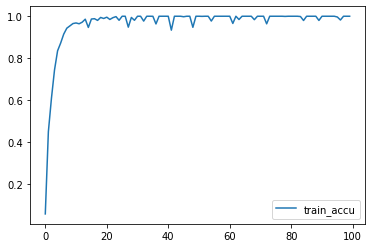

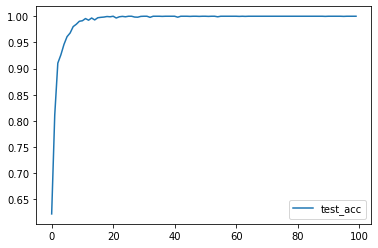

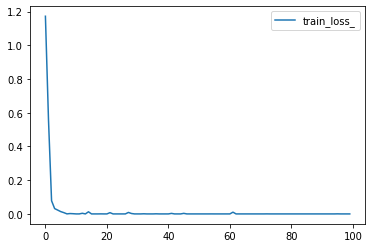

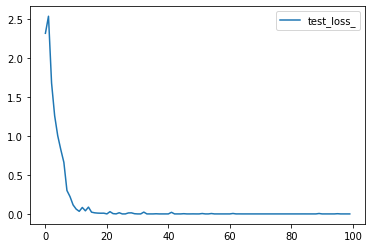

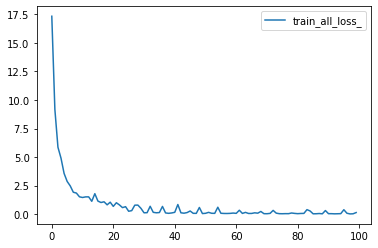

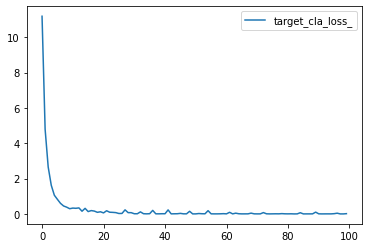

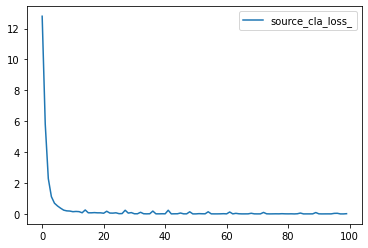

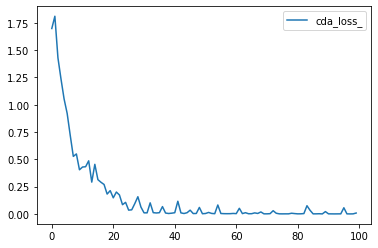

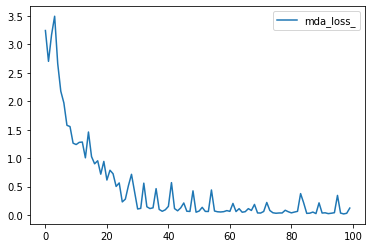

In [10]:
a=[train_accu,test_acc,train_loss_,test_loss_,train_all_loss_,target_cla_loss_,source_cla_loss_,cda_loss_,mda_loss_]
b=['train_accu','test_acc','train_loss_','test_loss_','train_all_loss_','target_cla_loss_','source_cla_loss_','cda_loss_','mda_loss_']
for i in range(len(a)): 
    plt.plot(a[i],label=b[i])
    plt.legend()
    plt.show()